In [213]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
warnings.simplefilter("ignore")

In [5]:
data = pd.read_csv("processed_text_df.csv")
data.drop(["Unnamed: 0"], axis=1, inplace=True)
data.head()

,url,class,processed_text
0,https://www.geeksforgeeks.org/machine-learning/,Machine Learning,machine learning geeksforgeeks skip content co...
1,https://machinelearningmastery.com/start-here/,Machine Learning,moment machinelearningmasterycom checking site...
2,https://www.techtarget.com/searchenterpriseai/...,Machine Learning,machine learning important searchenterpriseai ...
3,https://azure.microsoft.com/en-us/services/mac...,Machine Learning,azure machine learning ml service microsoft az...
4,https://ai.google/education/,Machine Learning,education google ai ai ai responsibility resea...


### Remove the null values

In [63]:
indices = data["processed_text"].isna()

In [65]:
for to_drop, index in enumerate(indices):
    if index == True:
        data.drop(to_drop, inplace=True)

In [66]:
sum(data["processed_text"].isna())

0

### Split the data 
- Using 70% training and 30% test set for the data

In [67]:
print("Total elements :", len(data))

Total elements : 2018


In [68]:
x_data = data[["processed_text"]]
y_data = data[["class"]]
print("Feature Vector : ")
x_data.head()

Feature Vector : 


,processed_text
0,machine learning geeksforgeeks skip content co...
1,moment machinelearningmasterycom checking site...
2,machine learning important searchenterpriseai ...
3,azure machine learning ml service microsoft az...
4,education google ai ai ai responsibility resea...


In [69]:
print("Class labels :")
y_data.head()

Class labels :


,class
0,Machine Learning
1,Machine Learning
2,Machine Learning
3,Machine Learning
4,Machine Learning


In [70]:
values = y_data["class"].value_counts()

In [71]:
class_labels = list(values.keys())

In [72]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=0.85)

### Distribution of Class labels 

#### Training Data

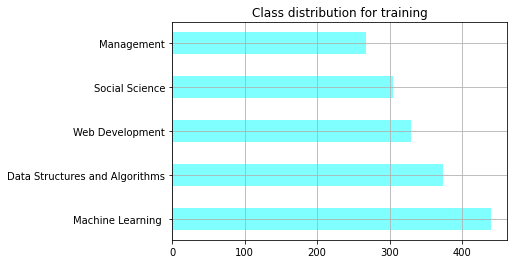

In [73]:
train_counts = y_train['class'].value_counts()
plt.title("Class distribution for training")
plt.barh(y=list(train_counts.keys()), width=train_counts.values,
         height=0.5, color='cyan', alpha=0.5)
plt.grid()

#### Testing Data

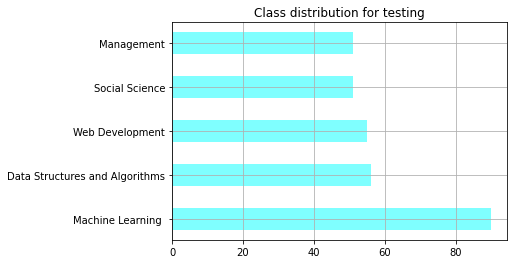

In [74]:
test_counts = y_test['class'].value_counts()
plt.title("Class distribution for testing")
plt.barh(y=list(test_counts.keys()), width=test_counts.values,
         height=0.5, color='cyan', alpha=0.5)
plt.grid()

### Fitting TfIdf

- Details : 
    - english stop words 
    - ngram is (1 -> 3) words 
    - Minimum word frequency is 0.5%

In [107]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), min_df=0.005)

In [108]:
tfidf.fit(x_train["processed_text"])

TfidfVectorizer(min_df=0.005, ngram_range=(1, 3), stop_words='english')

### Word Vocabulary

In [109]:
len(tfidf.get_feature_names())

54048

In [110]:
x_test

,processed_text
1085,frontier sociology skip main content top bar n...
1138,geography crash course geography 1 youtube pre...
1427,javascript available detected javascript disab...
1127,geography definition meaning merriam-webster m...
110,supervised machine learning regression classif...
...,...
381,moment machinelearningmasterycom checking site...
831,access denied access denied permission access ...
2014,process definition whatiscom whatiscom search ...
119,azure machine learning ml service microsoft az...


In [ ]:
train_vector = tfidf.transform(x_train["processed_text"])

In [113]:
test_vector = tfidf.transform(x_test["processed_text"])

In [119]:
class_labels

['Machine Learning ',
 'Data Structures and Algorithms',
 'Web Development',
 'Social Science',
 'Management']

In [120]:
class_mapping = {x: i for i, x in enumerate(class_labels)}
class_mapping

{'Machine Learning ': 0,
 'Data Structures and Algorithms': 1,
 'Web Development': 2,
 'Social Science': 3,
 'Management': 4}

In [131]:
y_train["class_labels"] = y_train["class"].apply(lambda x: class_mapping[x])
y_train.head()

,class,class_labels
1777,Management,4
879,Data Structures and Algorithms,1
375,Machine Learning,0
1699,Web Development,2
469,Machine Learning,0


In [132]:
y_test["class_labels"] = y_test["class"].apply(lambda x: class_mapping[x])
y_test.head()

,class,class_labels
1085,Social Science,3
1138,Social Science,3
1427,Web Development,2
1127,Social Science,3
110,Machine Learning,0


In [133]:
train_y = y_train["class_labels"]
test_y = y_test["class_labels"]
print(train_y[:10])

1777    4
879     1
375     0
1699    2
469     0
31      0
259     0
877     1
1064    3
341     0
Name: class_labels, dtype: int64


### Model Selection 
- Trying out random forest and decision tree based classifiers first 

In [150]:
from sklearn.tree import DecisionTreeClassifier

In [166]:
model = DecisionTreeClassifier(max_depth = 170, min_samples_leaf=1, max_features='sqrt', class_weight="balanced")

In [167]:
model.fit(train_vector, train_y)

DecisionTreeClassifier(class_weight='balanced', max_depth=170,
                       max_features='sqrt')

In [ ]:
model.score(test_vector, test_y)

In [169]:
from sklearn.ensemble import RandomForestClassifier

### Experimenting with Params
- Depth and Estimators -
    - [20, 200] in increments of 5 
    - [10, 80] in increments of 5 
    

In [299]:
depth = np.linspace(20, 100, 20, dtype = np.int32)
estimators = np.linspace(10, 80, 20, dtype = np.int32)
depth_grid, estimator_grid = np.meshgrid(depth, estimators, indexing = 'ij')

In [275]:
scores = np.zeros_like(depth_grid, dtype = np.float32)

for depth_id in range(len(depth)):
    for est_id in range(len(estimators)):
        # get vals
        depth = depth_grid[depth_id][est_id]
        estimator = estimator_grid[depth_id][est_id]
        
        # build and save 
        model = RandomForestClassifier(max_depth = depth, n_estimators = estimator, min_samples_leaf=3, max_features='sqrt', class_weight="balanced")
        model.fit(train_vector, train_y)
        scores[depth_id][est_id] = model.score(test_vector, test_y)

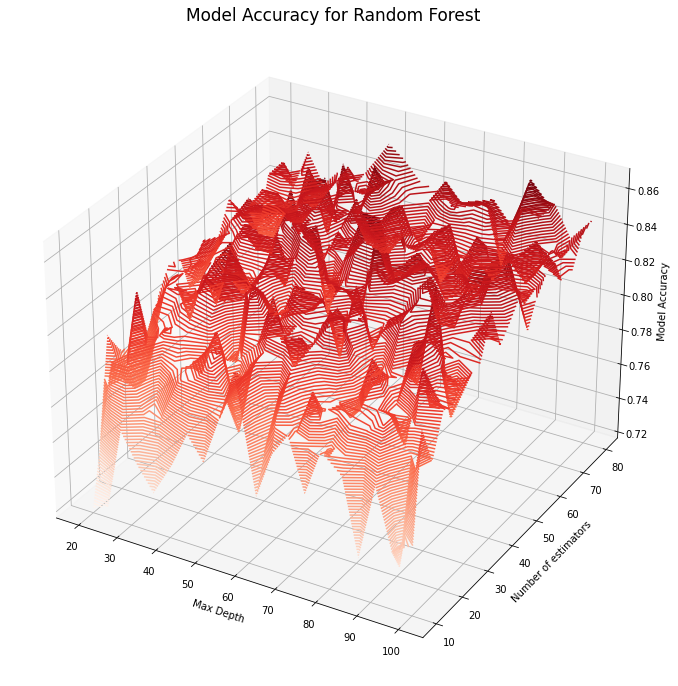

In [309]:
fig = plt.figure(figsize = (17,12))
ax = plt.axes(projection='3d')

ax.set_xlabel("Max Depth")
ax.set_ylabel("Number of estimators")
ax.set_zlabel("Model Accuracy")
ax.set_title("Model Accuracy for Random Forest", fontsize = 17)
# Data for a three-dimensional line
ax.contour3D(depth_grid, estimator_grid, scores, 120, cmap='Reds')
plt.savefig("Contour of Random Forest Accuracy", dpi = 300, transparent = False)

In [289]:
max_score_id = np.unravel_index(scores.argmax(), scores.shape)
print(max_score_id)

(12, 9)


In [300]:
best_depth = depth_grid[max_score_id[0]][max_score_id[1]]
best_estimators = estimator_grid[max_score_id[0]][max_score_id[1]]
print("Depth : ", best_depth)
print("Estimators : ", best_estimators)

Depth :  70
Estimators :  43


### Parameters
```
Depth :  70
Estimators :  43
```

## Feature Importances of the TfIdf dictionary

In [ ]:
# to do...